In [10]:
import cv2, json, glob, os, time, tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import PIL as pil
from PIL import Image
from matplotlib import pyplot as plt

from keras import backend as K
from keras.models import load_model

print(cv2.__version__)
print(pil.__version__)

4.7.0
9.2.0


In [50]:
#json, img 파일 제목 저장
#일단은 양호에 한정

dir_1 = glob.glob('./유형별 두피 이미지/Training/Labels/*')
json_names = []
for temp_dir in dir_1:
    json_names += glob.glob(temp_dir + '/*.*')

temp_img_dir = glob.glob('./유형별 두피 이미지/Training/Images/*')
# print(len(temp_img_dir))  #should be 24
img_names = []
for temp in temp_img_dir:
    img_names += glob.glob(temp + '/*.*')

json_names=f=[json_names[i].replace('\\','/') for i in range(len(json_names))]
img_names=f=[img_names[i].replace('\\','/') for i in range(len(img_names))]
print(json_names[:5], end='\n\n')
print(img_names[:5])

['./유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.json', './유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0177_A2LEBJJDE00152B_1604650530904_6_BH.json', './유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0335_A2LEBJJDE00013X_1602916465540_6_BH.json', './유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0335_A2LEBJJDE000542_1605676381132_4_LH.json', './유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0425_A2LEBJJDE00079P_1605793927978_5_RH.json']

['./유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg', './유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0177_A2LEBJJDE00152B_1604650530904_6_BH.jpg', './유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0335_A2LEBJJDE00013X_1602916465540_6_BH.jpg', './유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0335_A2LEBJJDE000542_1605676381132_4_LH.jpg', './유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0425_A2LEBJJDE00079P_1605793927978_5_RH.jpg']


list

In [42]:
#Json 파일 로딩 확인
with open('./유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.json') as json_file:
    json_data = json.load(json_file)
    print(json_data)

json_string = json_data["image_id"]
print(json_string)

{'image_id': '0013_A2LEBJJDE00060O_1606550825417_3', 'image_file_name': '0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg', 'value_1': '0', 'value_2': '0', 'value_3': '0', 'value_4': '0', 'value_5': '0', 'value_6': '0'}
0013_A2LEBJJDE00060O_1606550825417_3


In [76]:
# CONCATENATE multiple JSON files into one dataframe

# https://stackoverflow.com/questions/57067551/how-to-read-multiple-json-files-into-pandas-dataframe
# insert in (): columns=['image_id', 'image_file_name', 'value_1', 'value_2', 'value_3', 'value_4', 'value_5', 'value_6'])
df1=pd.DataFrame()

for file in json_names:
    data = pd.read_json(file, lines=True) # read data frame from json file
    img_dir = './유형별 두피 이미지/Training/Images/' + data['image_file_name']    #[:-45]
    data.insert(2, 'img_dir', img_dir)  # data['img_dir']=img_dir
    df1=pd.concat([df1, data])

df1

,image_id,image_file_name,img_dir,value_1,value_2,value_3,value_4,value_5,value_6
0,0013_A2LEBJJDE00060O_1606550825417_3,0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg,./유형별 두피 이미지/Training/Images/0013_A2LEBJJDE000...,0,0,0,0,0,0
0,0177_A2LEBJJDE00152B_1604650530904_6,0177_A2LEBJJDE00152B_1604650530904_6_BH.jpg,./유형별 두피 이미지/Training/Images/0177_A2LEBJJDE001...,0,0,0,0,0,0
0,0335_A2LEBJJDE00013X_1602916465540_6,0335_A2LEBJJDE00013X_1602916465540_6_BH.jpg,./유형별 두피 이미지/Training/Images/0335_A2LEBJJDE000...,0,0,0,0,0,0
0,0335_A2LEBJJDE000542_1605676381132_4,0335_A2LEBJJDE000542_1605676381132_4_LH.jpg,./유형별 두피 이미지/Training/Images/0335_A2LEBJJDE000...,0,0,0,0,0,0
0,0425_A2LEBJJDE00079P_1605793927978_5,0425_A2LEBJJDE00079P_1605793927978_5_RH.jpg,./유형별 두피 이미지/Training/Images/0425_A2LEBJJDE000...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
0,9887_A2LEBJJDE00066H_1605155133469_6,9887_A2LEBJJDE00066H_1605155133469_6_BH.jpg,./유형별 두피 이미지/Training/Images/9887_A2LEBJJDE000...,0,2,2,0,0,3
0,9905_A2LEBJJDE00042M_1602729142776_4,9905_A2LEBJJDE00042M_1602729142776_4_LH.jpg,./유형별 두피 이미지/Training/Images/9905_A2LEBJJDE000...,2,0,1,0,0,3
0,9905_A2LEBJJDE00042M_1602729347625_4,9905_A2LEBJJDE00042M_1602729347625_4_LH.jpg,./유형별 두피 이미지/Training/Images/9905_A2LEBJJDE000...,1,0,1,0,1,3
0,9905_A2LEBJJDE00042M_1604108127168_4,9905_A2LEBJJDE00042M_1604108127168_4_LH.jpg,./유형별 두피 이미지/Training/Images/9905_A2LEBJJDE000...,0,2,1,0,0,3


In [80]:
img_id_l=[]

for idx, each in enumerate(json_names):
    # print(each)     #json 경로
    with open(each, 'r', encoding='UTF-8') as j:
        js=json.load(j)
        img_id_l.append(js["image_id"])

img_id_l[:5]

['0013_A2LEBJJDE00060O_1606550825417_3',
 '0177_A2LEBJJDE00152B_1604650530904_6',
 '0335_A2LEBJJDE00013X_1602916465540_6',
 '0335_A2LEBJJDE000542_1605676381132_4',
 '0425_A2LEBJJDE00079P_1605793927978_5']

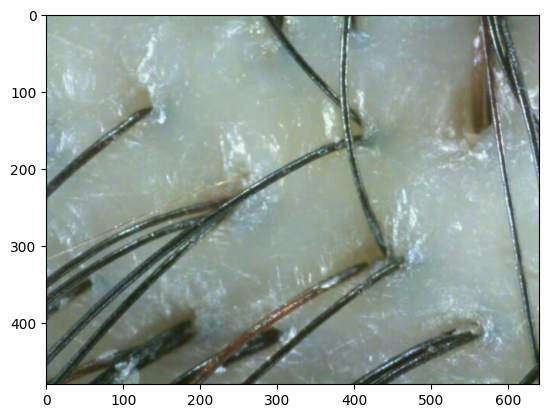

In [12]:
#테스트 이미지 출력
test_img = Image.open('./유형별 두피 이미지/Training/원천_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg')

plt.imshow(test_img)
plt.show()